# ESG 지표 분류모델 데이터 전처리, EDA, 모델 학습 및 성능검증

## 목차
- X_features
1. A_SIZE : log(total_asset), log(기업의 총자산)
2. LEV : Leverage, 총 부채 / 총 자산
3. TQ : Tobins'Q, (시가총액 + 총 부채) / 총 자산
4. FOR : Foreign Ownership Ratio, 외국인 지분율
5. MSE : Major Shareholder Equity, 주요주주지분
6. ROA : Return On Assets, 총 자산 수익률
7. ADV : Advertising Intensity, 광고비
8. SGR : Sales Growth Rate, 매출성장률
9. R&D : Research & Development, 연구개발비

## 1. 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
#csv 파일 불러오기
df = pd.read_csv('data/fin/fin_total_all_years.csv')
df

,corp_code,corp_name,year,A_SIZE,LEV,TQ,stock_code,FOR,MSE,ROA,ADV,SGR,R&D,ESG,E,S,G
0,365387,AJ네트웍스,2019,28.220615,80.738103,93.642922,95570,7.95,50.05,2.336252,40.874166,1504.195815,NaN,B,D,B,B
1,125080,AK홀딩스,2019,29.096118,66.960476,77.551265,6840,12.75,64.89,1.325746,169.563436,130.306046,51.344764,B+,C,B+,B+
2,219097,BGF,2019,28.136260,7.791009,40.132026,27410,9.00,69.98,1.056805,NaN,893.977878,NaN,B+,B,A,B+
3,1263022,BGF리테일,2019,28.406859,71.340792,206.196590,282330,34.12,55.42,6.968159,3.526700,294.684822,NaN,A,B+,B+,A
4,858364,BNK금융지주,2019,NaN,NaN,NaN,138930,51.70,9.19,NaN,NaN,NaN,NaN,A+,B+,A+,A+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,111421,휴니드테크놀러지스,2024,26.208110,28.723503,73.880892,5870,24.83,22.83,4.457985,22.652109,85.504278,498.391624,D,C,C,D
4382,362238,휴비스,2024,27.363636,69.298348,80.927896,79980,3.38,51.00,-17.323999,1.608714,126.643156,42.896749,B+,B+,A,B+
4383,156488,휴스틸,2024,27.989580,21.772717,36.612095,5010,4.20,48.06,1.558903,1.330981,-546.170912,4.621818,C,C,C,C
4384,103176,흥국화재,2024,30.187837,94.007928,95.836360,540,2.17,79.19,0.827643,NaN,NaN,73.914884,B+,B+,B,B+


In [3]:
#결측치
df.isnull().sum()

corp_code        0
corp_name        0
year             0
A_SIZE         174
LEV            174
TQ             174
stock_code       0
FOR             72
MSE             49
ROA             55
ADV            989
SGR            267
R&D           1268
ESG              0
E                0
S                0
G                0
dtype: int64

#### 결측치 처리 (1) / null값 이 있는 행 전부 삭제

In [4]:
# 결측치 처리 (1) / null값 이 있는 행 전부 삭제
df_notn = df.dropna().copy()
# df_notn = df_notn[df_notn['corp_name'].map(df_notn['corp_name'].value_counts()) == 6]

print(f"정제 전 기업 수: {len(df)}개")
print(f"정제 후(비금융) 기업 수: {len(df_notn)}개")

정제 전 기업 수: 4386개
정제 후(비금융) 기업 수: 2522개


In [5]:
#널값이 존재하는 기업 리스트 확인
df_notn.isnull().sum()

corp_code     0
corp_name     0
year          0
A_SIZE        0
LEV           0
TQ            0
stock_code    0
FOR           0
MSE           0
ROA           0
ADV           0
SGR           0
R&D           0
ESG           0
E             0
S             0
G             0
dtype: int64

In [6]:
#ESG 기업등급을 숫자로 변환
'''
논문에서는 KCGS가 평가하는 S등급부터 D등급까지의 7단계를 기준으로 7점 척도의 서열형 변환을 수행했음.
비록 지금 데이터에는 'S'등급이 없더라도, 논문과 동일한 가중치를 유지하기 위해 아래와 같이 딕셔너리를 만듦.
'''
# 논문의 방법론대로 딕셔너리 생성

# 1. 등급 매핑 딕셔너리 (논문의 7점 척도 기준)
esg_mapping = {
    'S': 7, 'A+': 6, 'A': 5, 'B+': 4, 'B': 3, 'C': 2, 'D': 1
}

# 2. ESG 등급 컬럼들을 숫자로 변환
esg_cols = ['ESG', 'E', 'S', 'G']
for col in esg_cols:
    # '-' 표시된 결측치는 자동으로 NaN이 되도록 매핑 
    df_notn[col] = df_notn[col].map(esg_mapping)

# 3. 기업별(corp_name) 평균값으로 결측치 채우기 
# 논문에서는 데이터 전처리 시 결측치를 해당 기업의 평균값으로 대체했음 
for col in esg_cols:
    df_notn[col] = df_notn.groupby('corp_name')[col].transform(lambda x: x.fillna(x.mean()))

# 4. 여전히 NaN인 경우(전 기간 등급 없음)는 논문 원칙에 따라 삭제
df_notn = df_notn.dropna(subset=esg_cols)

print(f"✨ 정제 완료! 현재 남은 기업 데이터: {len(df_notn)}행")

✨ 정제 완료! 현재 남은 기업 데이터: 2522행


In [7]:
df_notn.describe()

,corp_code,year,A_SIZE,LEV,TQ,stock_code,FOR,MSE,ROA,ADV,SGR,R&D,ESG,E,S,G
count,2.522000e+03,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000
mean,2.913180e+05,2021.622125,27.682331,47.161947,264.097780,48464.095956,11.189060,43.927752,1.830101,162.149970,944.718626,229.177703,3.045599,2.917129,3.516257,3.088422
std,3.019324e+05,1.658807,1.739716,19.782114,4185.017621,72324.547414,12.882928,16.407453,7.516371,529.837035,4251.900273,619.714982,1.509688,1.538825,1.810962,1.404826
min,1.009390e+05,2019.000000,18.656155,1.778130,27.515971,20.000000,0.020000,0.090000,-95.635348,0.000059,-8628.190391,0.000178,1.000000,1.000000,1.000000,1.000000
25%,1.255210e+05,2020.000000,26.503329,30.759043,72.139273,4690.000000,2.330000,32.635000,0.161502,3.709857,-319.941260,11.148346,2.000000,2.000000,2.000000,2.000000
50%,1.544620e+05,2022.000000,27.453394,48.560590,87.983410,12390.000000,6.015000,43.970000,2.436483,21.457622,497.926216,59.241045,3.000000,3.000000,4.000000,3.000000
75%,2.990020e+05,2023.000000,28.709317,62.114590,118.359520,68290.000000,15.310000,55.010000,5.032360,116.904422,1539.724861,194.363337,4.000000,4.000000,5.000000,4.000000
max,1.319808e+06,2024.000000,33.874279,122.369944,148504.678647,300720.000000,79.000000,100.000000,48.908083,7937.739889,168171.366723,9516.957886,6.000000,6.000000,6.000000,6.000000


In [8]:
df_notn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2522 entries, 1 to 4383
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   corp_code   2522 non-null   int64  
 1   corp_name   2522 non-null   object 
 2   year        2522 non-null   int64  
 3   A_SIZE      2522 non-null   float64
 4   LEV         2522 non-null   float64
 5   TQ          2522 non-null   float64
 6   stock_code  2522 non-null   int64  
 7   FOR         2522 non-null   float64
 8   MSE         2522 non-null   float64
 9   ROA         2522 non-null   float64
 10  ADV         2522 non-null   float64
 11  SGR         2522 non-null   float64
 12  R&D         2522 non-null   float64
 13  ESG         2522 non-null   int64  
 14  E           2522 non-null   int64  
 15  S           2522 non-null   int64  
 16  G           2522 non-null   int64  
dtypes: float64(9), int64(7), object(1)
memory usage: 354.7+ KB


In [9]:
df_notn['ESG'].value_counts()

ESG
2    636
5    562
1    484
4    427
3    357
6     56
Name: count, dtype: int64

In [10]:
'''
논문처럼 '기업별 평균값'으로 결측치를 채웠기때문에,
이때 평균값이 4.25나 5.5처럼 나올 수 있음.
따라서 수치로 변환한 ESG등급을 반올림하여 정수로 변환해주어야함
'''


# ESG 관련 4개 컬럼에 대해 정수 변환을 수행
esg_cols = ['ESG', 'E', 'S', 'G']

for col in esg_cols:
    # 1. 반올림(.round())을 하고 
    # 2. 정수형(.astype(int))으로 변환
    df_notn[col] = df_notn[col].round().astype(int)

# 잘 바뀌었는지 확인
print(df_notn[esg_cols].head())

    ESG  E  S  G
1     4  2  4  4
6     5  3  5  5
10    5  5  6  5
12    3  1  3  3
18    3  3  2  3


In [11]:
from sklearn.preprocessing import StandardScaler

# 1. 원본 데이터를 안전하게 복사해서 새로운 변수 df_final 만들기
df_final = df_notn.copy()

# 2. 정규화(Standardization)를 적용할 독립 변수 리스트
# ESG 등급을 맞추기 위한 재무 및 기업 정보 리스트 생성
features_to_scale = [
    'ROA', 'ADV', 'SGR', 'LEV', 'R&D', 'A_SIZE', 'MSE', 'FOR', 'TQ'
]

# 3. StandardScaler 객체 생성 및 적용
scaler = StandardScaler()

# df_final의 해당 컬럼들만 평균 0, 표준편차 1로 정규화
df_final[features_to_scale] = scaler.fit_transform(df_final[features_to_scale])

# 4. 결과 확인
print("✨ 새로운 변수 'df_final'에 정규화 데이터 저장 완료")
print(df_final[features_to_scale].head())

✨ 새로운 변수 'df_final'에 정규화 데이터 저장 완료
         ROA       ADV       SGR       LEV       R&D    A_SIZE       MSE  \
1  -0.067114  0.013995 -0.191579  1.001028 -0.287016  0.812816  1.277859   
6  -0.136814  0.024948  0.116898  0.841604 -0.145527  2.096769 -0.041316   
10 -0.146805 -0.217261  0.241737  0.847410 -0.361902  1.849820 -0.128489   
12 -0.082140  0.252395 -0.208412 -0.265997 -0.166843 -0.611846 -0.009007   
18  0.753164 -0.303135 -0.167207 -0.800503 -0.223055 -0.082618  0.386623   

         FOR        TQ  
1   0.121187 -0.044584  
6   0.524126 -0.046200  
10  0.688718 -0.044384  
12 -0.678479 -0.041453  
18 -0.376469 -0.047942  


'\n왜 정규화할 때 Min-Max가 아니라 표준화를 하는가?\n한 기업의 성장률이 혼자 1000%면, 그 기업이 1이 되고 나머지 기업들은 0.1에 가까운 값을 가지게 된다.\n기업별로 매출액 등 또한 값이 천차만별이니, 이상치에 민감한 Min-Max보다 이상치에 강한 표준화를 사용하는 게 타당하다.\n'

In [13]:
df_final.shape

(2522, 17)

## 2. 다중회귀 분석 / 리니어 회귀


                            OLS Regression Results
Dep. Variable:       E               R-squared:           0.474
Model:               LinearRegression Adj. R-squared:      0.472
Method:              Least Squares   F-statistic:         207.2
No. Observations:    2079            Prob (F-statistic):  1.11e-16
Df Residuals:        2069            Log-Likelihood:      -3153.3
Df Model:            9               AIC:                 6326.7
Covariance Type:     nonrobust       BIC:                 6383.1
                      coef    std err        t    P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
const               2.8355     0.0242  117.239    0.000      2.788      2.883
ROA                 0.0014     0.0269    0.051    0.959     -0.051      0.054
SGR                -0.0281     0.0243   -1.157    0.248     -0.076      0.020
LEV                 0.0913     0.0273    3.344    0.001      0.038      0.145
A_SIZE              1.0

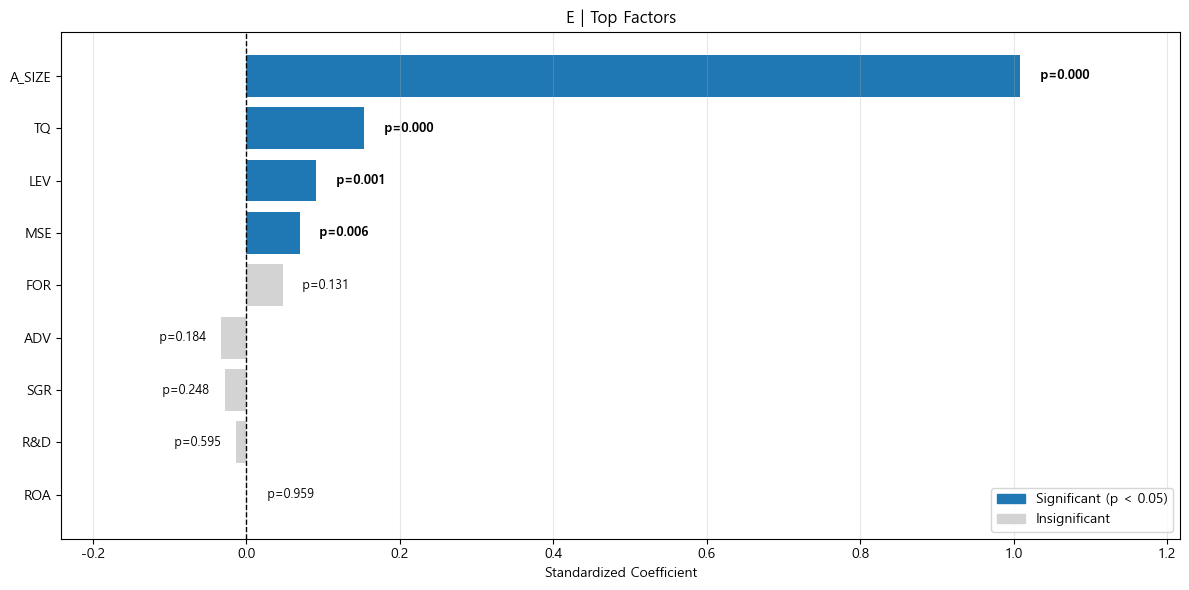




                            OLS Regression Results
Dep. Variable:       S               R-squared:           0.465
Model:               LinearRegression Adj. R-squared:      0.462
Method:              Least Squares   F-statistic:         199.5
No. Observations:    2079            Prob (F-statistic):  1.11e-16
Df Residuals:        2069            Log-Likelihood:      -3492.0
Df Model:            9               AIC:                 7004.0
Covariance Type:     nonrobust       BIC:                 7060.4
                      coef    std err        t    P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
const               3.4545     0.0285  121.364    0.000      3.399      3.510
ROA                -0.0230     0.0317   -0.727    0.467     -0.085      0.039
SGR                -0.0216     0.0286   -0.754    0.451     -0.078      0.035
LEV                 0.0880     0.0321    2.737    0.006      0.025      0.151
A_SIZE              1

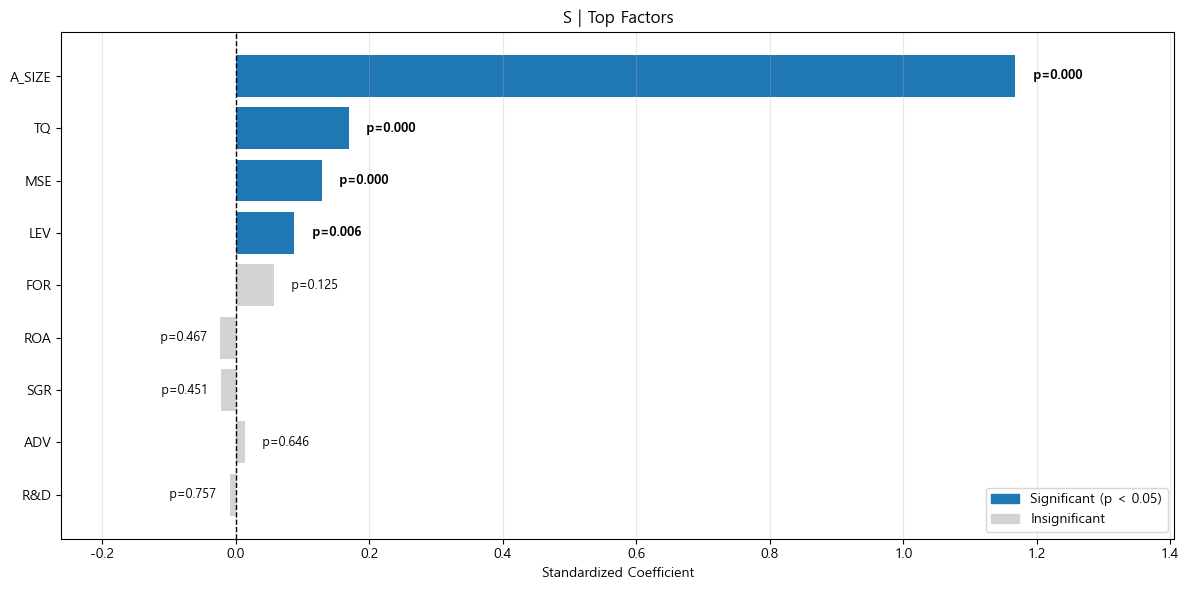




                            OLS Regression Results
Dep. Variable:       G               R-squared:           0.286
Model:               LinearRegression Adj. R-squared:      0.283
Method:              Least Squares   F-statistic:         92.1
No. Observations:    2079            Prob (F-statistic):  1.11e-16
Df Residuals:        2069            Log-Likelihood:      -3260.9
Df Model:            9               AIC:                 6541.7
Covariance Type:     nonrobust       BIC:                 6598.1
                      coef    std err        t    P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
const               3.1549     0.0255  123.870    0.000      3.105      3.205
ROA                 0.0048     0.0283    0.170    0.865     -0.051      0.060
SGR                -0.0498     0.0256   -1.944    0.052     -0.100      0.000
LEV                -0.0028     0.0288   -0.098    0.922     -0.059      0.054
A_SIZE              0.

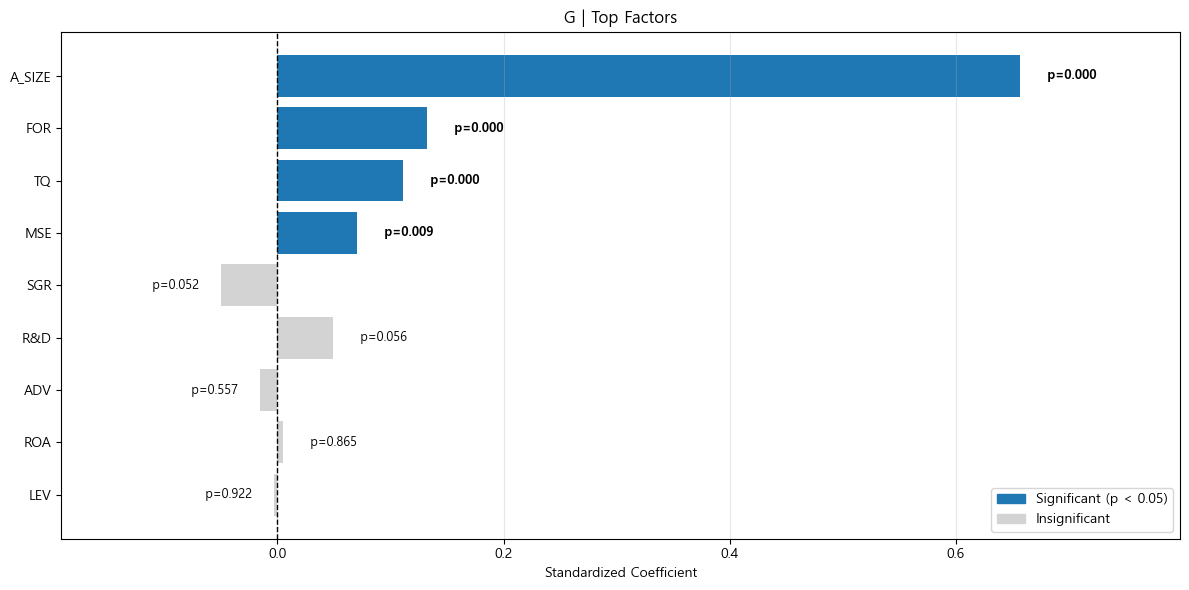




                            OLS Regression Results
Dep. Variable:       ESG             R-squared:           0.440
Model:               LinearRegression Adj. R-squared:      0.437
Method:              Least Squares   F-statistic:         180.3
No. Observations:    2079            Prob (F-statistic):  1.11e-16
Df Residuals:        2069            Log-Likelihood:      -3161.1
Df Model:            9               AIC:                 6342.2
Covariance Type:     nonrobust       BIC:                 6398.6
                      coef    std err        t    P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
const               3.0462     0.0243  125.481    0.000      2.999      3.094
ROA                -0.0121     0.0270   -0.449    0.654     -0.065      0.041
SGR                -0.0348     0.0244   -1.424    0.155     -0.083      0.013
LEV                 0.0551     0.0274    2.010    0.045      0.001      0.109
A_SIZE              0

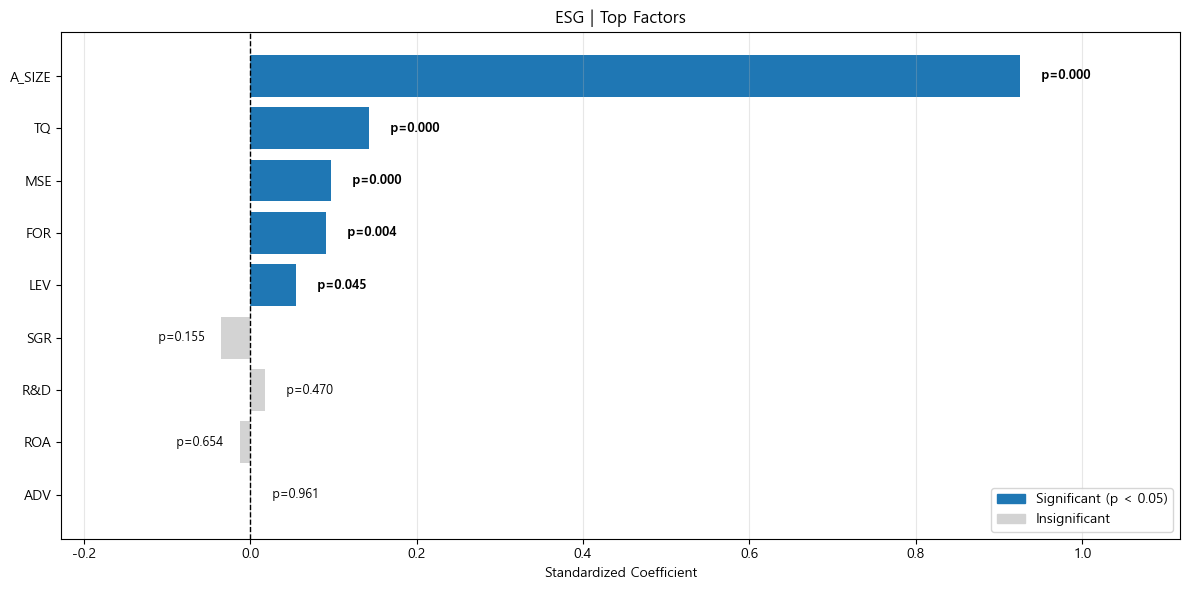

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # 범례(Legend) 생성을 위해 추가
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# =============================================================================
# 1. [함수] Sklearn 결과를 OLS 리포트 형식으로 출력하고, 통계 데이터를 반환
# =============================================================================
def print_sklearn_summary(model, X, y, features, target_name):
    """
    sklearn 모델의 통계량을 계산하여:
    1. statsmodels 스타일의 요약표를 출력하고
    2. 시각화를 위한 데이터프레임을 반환합니다.
    """
    # --- 통계량 계산 ---
    predictions = model.predict(X)
    residuals = y - predictions
    n = len(y)
    p = len(features) 
    
    r2 = r2_score(y, predictions)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    SSE = np.sum(residuals ** 2)
    MSE = SSE / (n - p - 1)
    
    # 표준오차 계산 (공분산 행렬)
    X_design = np.column_stack([np.ones(n), X])
    try:
        cov_matrix = np.linalg.inv(np.dot(X_design.T, X_design)) * MSE
        se = np.sqrt(np.diagonal(cov_matrix))
    except:
        se = np.zeros(p + 1)

    # 계수 및 통계량
    params = np.append(model.intercept_, model.coef_)
    t_stats = params / se
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - p - 1)) for t in t_stats]
    
    # 신뢰구간
    t_critical = stats.t.ppf(0.975, n - p - 1)
    conf_lower = params - t_critical * se
    conf_upper = params + t_critical * se
    
    # F-statistic
    SST = np.sum((y - np.mean(y)) ** 2)
    SSR = SST - SSE
    F_stat = (SSR / p) / (SSE / (n - p - 1))
    prob_f_stat = 1 - stats.f.cdf(F_stat, p, n - p - 1)
    
    log_likelihood = -n/2 * (np.log(2 * np.pi) + np.log(MSE) + 1)
    aic = -2 * log_likelihood + 2 * (p + 1)
    bic = -2 * log_likelihood + (p + 1) * np.log(n)

    # --- 1. 리포트 출력 ---
    print(f"\n                            OLS Regression Results")
    print("=" * 78)
    print(f"{'Dep. Variable:':<20} {target_name:<15} {'R-squared:':<20} {r2:.3f}")
    print(f"{'Model:':<20} {'LinearRegression':<15} {'Adj. R-squared:':<20} {adj_r2:.3f}")
    print(f"{'Method:':<20} {'Least Squares':<15} {'F-statistic:':<20} {F_stat:.1f}")
    print(f"{'No. Observations:':<20} {n:<15} {'Prob (F-statistic):':<20} {prob_f_stat:.2e}")
    print(f"{'Df Residuals:':<20} {n-p-1:<15} {'Log-Likelihood:':<20} {log_likelihood:.1f}")
    print(f"{'Df Model:':<20} {p:<15} {'AIC:':<20} {aic:.1f}")
    print(f"{'Covariance Type:':<20} {'nonrobust':<15} {'BIC:':<20} {bic:.1f}")
    print("=" * 78)
    print(f"{'':<15} {'coef':>10} {'std err':>10} {'t':>8} {'P>|t|':>8} {'[0.025':>10} {'0.975]':>10}")
    print("-" * 78)
    
    full_feat_names = ['const'] + features
    for i, name in enumerate(full_feat_names):
        print(f"{name:<15} {params[i]:10.4f} {se[i]:10.4f} {t_stats[i]:8.3f} {p_values[i]:8.3f} {conf_lower[i]:10.3f} {conf_upper[i]:10.3f}")
    print("=" * 78)
    
    # --- 2. 데이터 반환 (시각화용) ---
    stats_df = pd.DataFrame({
        'Variable': full_feat_names,
        'Coefficient': params,
        'P_value': p_values
    })
    return stats_df

# =============================================================================
# 2. [함수] 시각화 개선 (범례 추가 + 텍스트 겹침 방지)
# =============================================================================
def plot_sklearn_coef(df_stats, target_name, alpha=0.05, top_n=10):
    # const(상수항) 제외
    df_plot = df_stats[df_stats['Variable'] != 'const'].copy()
    
    # 절대값 기준 정렬
    df_plot['abs_coef'] = df_plot['Coefficient'].abs()
    df_plot = df_plot.sort_values('abs_coef', ascending=False).head(top_n)

    # 색상 (P < 0.05 : 파랑, 그 외 : 회색)
    colors = df_plot['P_value'].apply(lambda x: 'tab:blue' if x < alpha else 'lightgray')

    plt.figure(figsize=(12, 6)) # 그래프 너비 확보
    bars = plt.barh(df_plot['Variable'], df_plot['Coefficient'], color=colors)
    
    plt.axvline(0, linestyle='--', linewidth=1, color='black')
    plt.title(f'{target_name} | Top Factors')
    plt.xlabel('Standardized Coefficient')

    # --- [개선 1] 범례(Legend) 추가 ---
    blue_patch = mpatches.Patch(color='tab:blue', label='Significant (p < 0.05)')
    gray_patch = mpatches.Patch(color='lightgray', label='Insignificant')
    plt.legend(handles=[blue_patch, gray_patch], loc='lower right')
    
    # --- [개선 2] 텍스트 겹침 방지 (X축 여백 자동 조절) ---
    max_val = df_plot['Coefficient'].max()
    min_val = df_plot['Coefficient'].min()
    padding = (max_val - min_val) * 0.2 # 좌우 20% 여유 공간 확보
    plt.xlim(min_val - padding, max_val + padding)

    # P-value 라벨링 (막대 끝에서 겹치지 않게 배치)
    for bar, pval in zip(bars, df_plot['P_value']):
        width = bar.get_width()
        
        # 막대 방향에 따라 텍스트 위치 및 정렬 방향 결정
        # 양수 막대 -> 오른쪽 끝에, 왼쪽 정렬
        # 음수 막대 -> 왼쪽 끝에, 오른쪽 정렬
        label_x_pos = width + (0.02 if width >= 0 else -0.02)
        ha_align = 'left' if width >= 0 else 'right'
        
        plt.text(
            label_x_pos, 
            bar.get_y() + bar.get_height()/2, 
            f' p={pval:.3f}', 
            va='center', 
            ha=ha_align, 
            fontsize=9,
            fontweight='bold' if pval < 0.05 else 'normal' # 유의하면 굵게 표시
        )

    plt.gca().invert_yaxis() # 상위 변수가 위로 오도록
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    

# =============================================================================
# 3. [실행부] 모델링 -> 리포트 출력 -> 시각화
# =============================================================================
targets = ['E', 'S', 'G', 'ESG']
base_features = [
    'ROA', 'SGR', 'LEV', 'A_SIZE', 'MSE',
    'FOR', 'TQ', 'ADV', 'R&D'
]

# (데이터가 준비되어 있다고 가정)
for target in targets:
    # 1. Train / Test Split
    test_mask = (df_final['year'] == 2024)
    train_df = df_final[~test_mask]
    
    X_train = train_df[base_features]
    y_train = train_df[target]
    
    # 2. Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # 3. 모델 학습
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # 4. ★ 리포트 출력 및 통계 데이터 받기 ★
    stats_df = print_sklearn_summary(model, X_train_scaled, y_train, base_features, target)
    
    # 5. ★ 개선된 시각화 그리기 ★
    plot_sklearn_coef(stats_df, target)
    
    print("\n" + "="*80 + "\n")


=== E 등급 예측 모델 분석 결과 ===
[다중회귀 E모델 성능 보고서]
MAE:  0.9696
MSE:  1.4422
RMSE: 1.2009
R2:   0.4229
------------------------------------------------------------


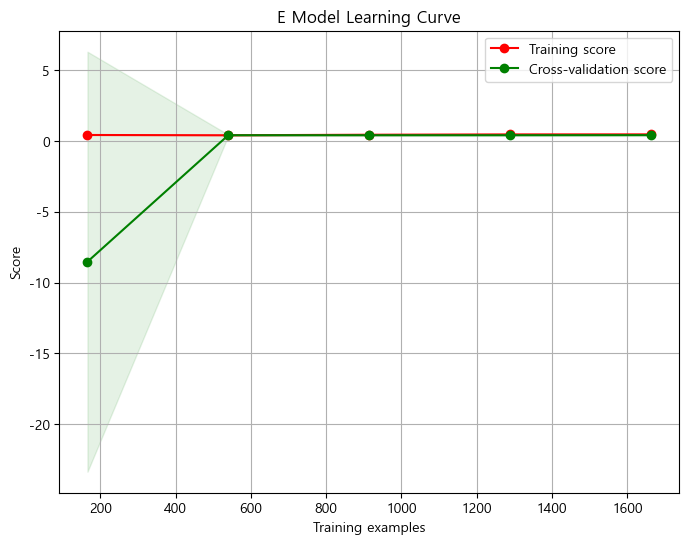

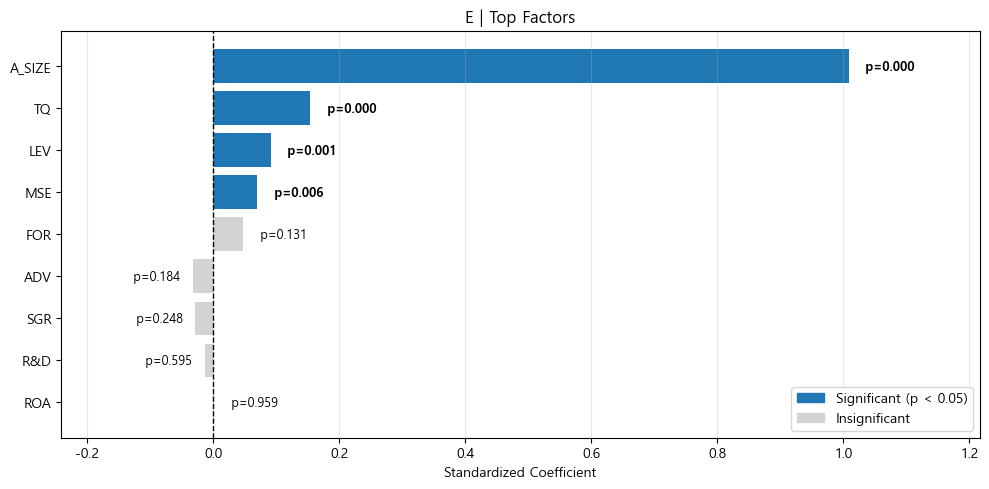



=== S 등급 예측 모델 분석 결과 ===
[다중회귀 S모델 성능 보고서]
MAE:  1.2196
MSE:  2.1264
RMSE: 1.4582
R2:   0.4502
------------------------------------------------------------


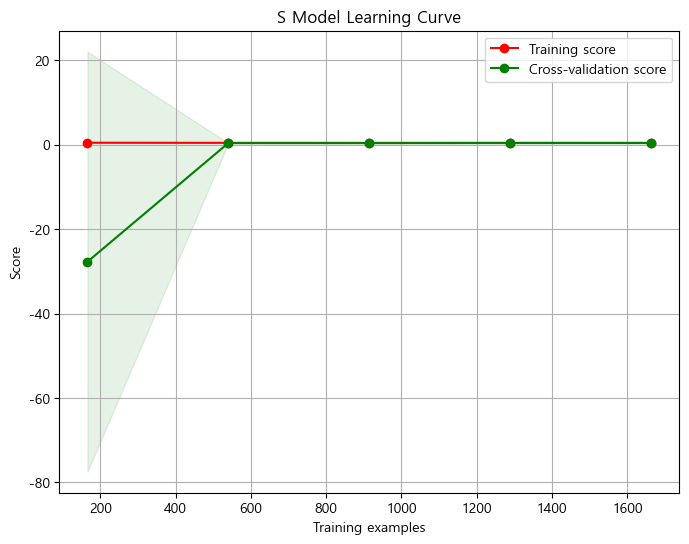

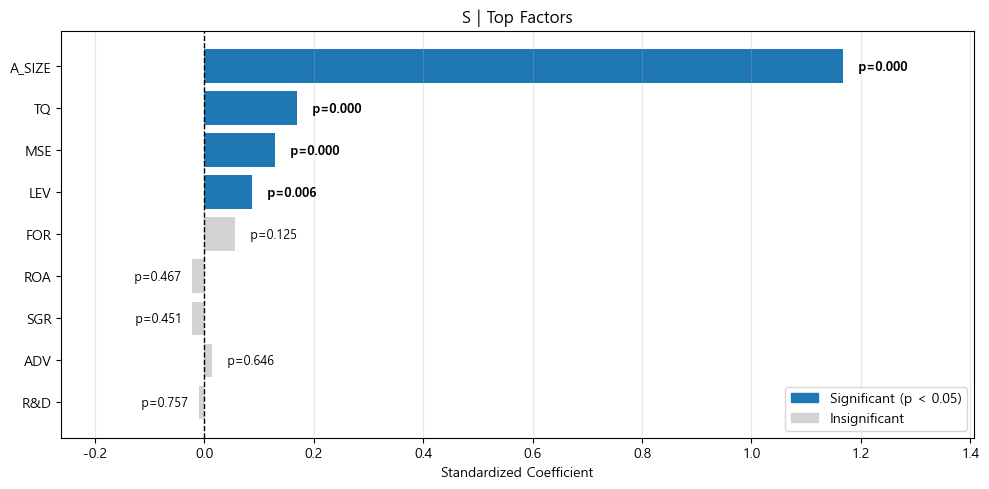



=== G 등급 예측 모델 분석 결과 ===
[다중회귀 G모델 성능 보고서]
MAE:  1.1214
MSE:  1.7310
RMSE: 1.3157
R2:   0.2444
------------------------------------------------------------


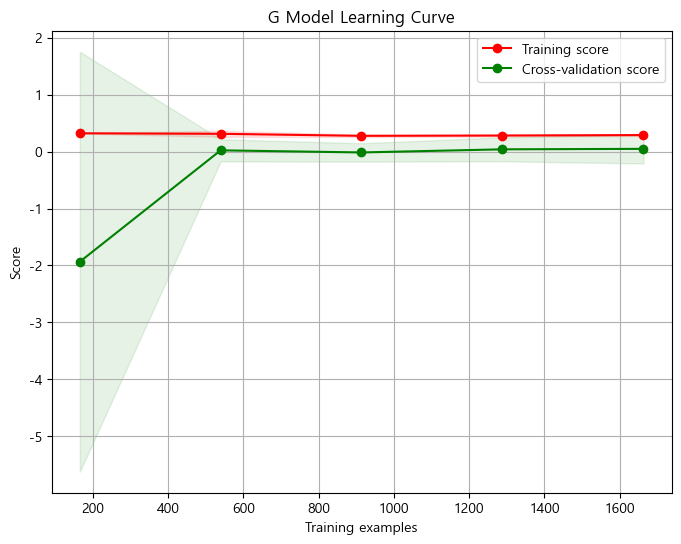

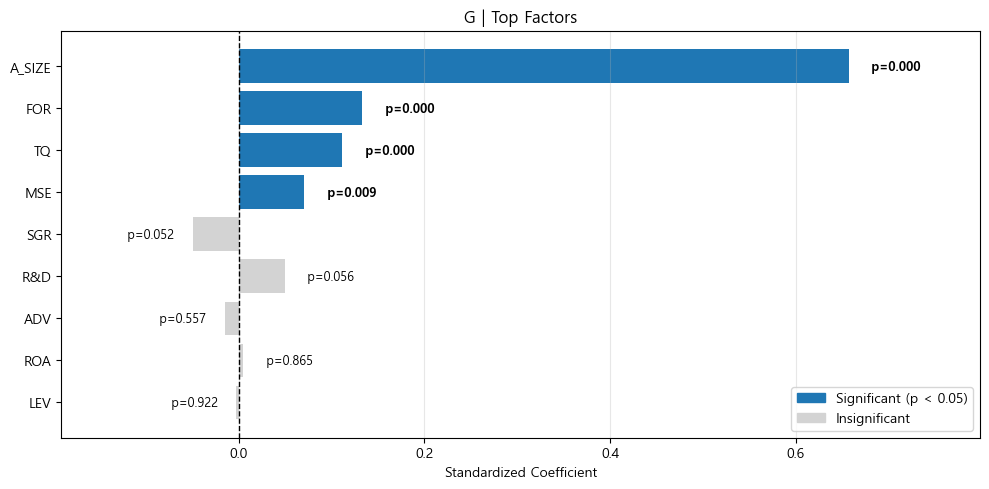



=== ESG 등급 예측 모델 분석 결과 ===
[다중회귀 ESG모델 성능 보고서]
MAE:  1.0489
MSE:  1.5217
RMSE: 1.2336
R2:   0.4484
------------------------------------------------------------


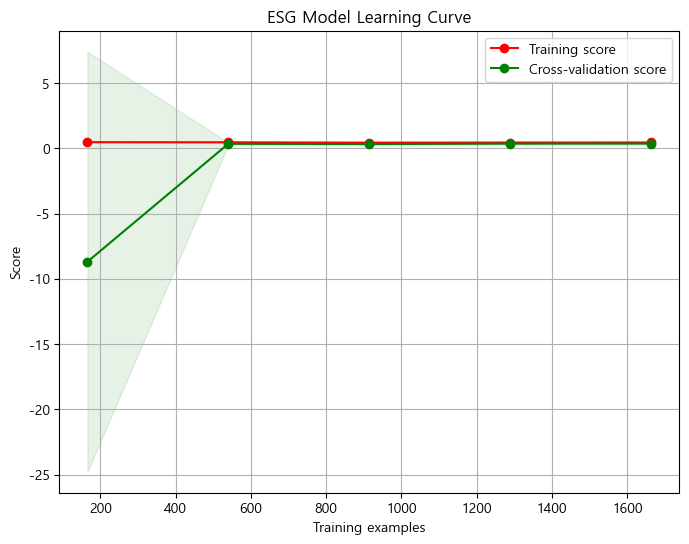

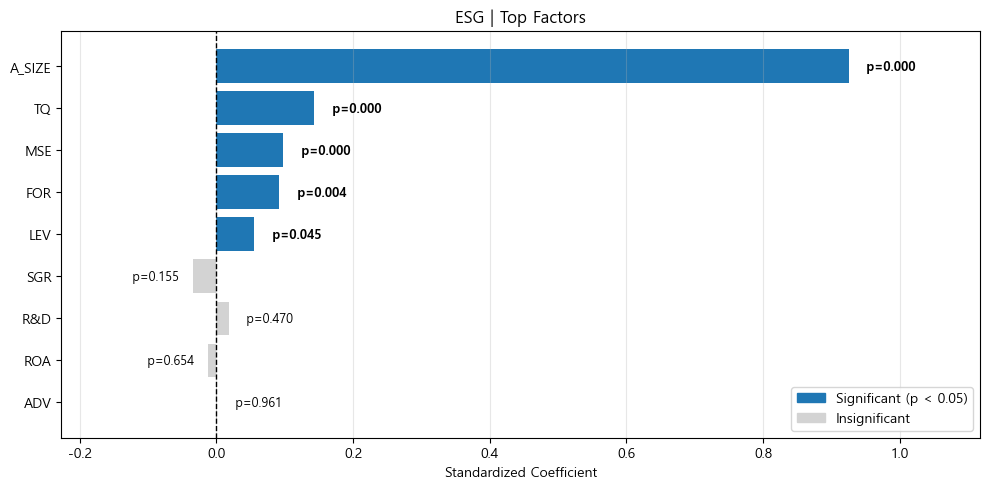

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import learning_curve # ★ 핵심 추가 라이브러리

# =============================================================================
# 1. [함수] Learning Curve (학습 곡선) 시각화
# =============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    데이터 개수 변화에 따른 Training Score와 Cross-Validation Score를 시각화합니다.
    (이미지 image_a42a0d.png 와 동일한 형태)
    """
    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # learning_curve 함수로 점수 계산
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='r2'
    )

    # 평균과 표준편차 계산
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    # 표준편차 범위 색칠 (투명도 조절)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # 평균 점수 선 그래프 그리기
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# =============================================================================
# 2. [함수] 통계량 계산 (기존 유지 - 시각화용 데이터 반환)
# =============================================================================
def get_model_stats(model, X, y, features):
    predictions = model.predict(X)
    residuals = y - predictions
    n = len(y)
    p = len(features)
    
    SSE = np.sum(residuals ** 2)
    MSE = SSE / (n - p - 1)
    
    try:
        X_design = np.column_stack([np.ones(n), X])
        cov_matrix = np.linalg.inv(np.dot(X_design.T, X_design)) * MSE
        se = np.sqrt(np.diagonal(cov_matrix))
    except:
        se = np.zeros(p + 1)

    params = np.append(model.intercept_, model.coef_)
    t_stats = params / se
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - p - 1)) for t in t_stats]
    
    full_feat_names = ['const'] + features
    
    return pd.DataFrame({'Variable': full_feat_names, 'Coefficient': params, 'P_value': p_values})

# =============================================================================
# 3. [함수] 계수 막대 그래프 (기존 유지)
# =============================================================================
def plot_sklearn_coef(df_stats, target_name, alpha=0.05, top_n=10):
    df_plot = df_stats[df_stats['Variable'] != 'const'].copy()
    df_plot['abs_coef'] = df_plot['Coefficient'].abs()
    df_plot = df_plot.sort_values('abs_coef', ascending=False).head(top_n)
    colors = df_plot['P_value'].apply(lambda x: 'tab:blue' if x < alpha else 'lightgray')

    plt.figure(figsize=(10, 5))
    bars = plt.barh(df_plot['Variable'], df_plot['Coefficient'], color=colors)
    plt.axvline(0, linestyle='--', linewidth=1, color='black')
    plt.title(f'{target_name} | Top Factors')
    plt.xlabel('Standardized Coefficient')

    blue_patch = mpatches.Patch(color='tab:blue', label='Significant (p < 0.05)')
    gray_patch = mpatches.Patch(color='lightgray', label='Insignificant')
    plt.legend(handles=[blue_patch, gray_patch], loc='lower right')
    
    max_val = df_plot['Coefficient'].max()
    min_val = df_plot['Coefficient'].min()
    padding = (max_val - min_val) * 0.2
    plt.xlim(min_val - padding, max_val + padding)

    for bar, pval in zip(bars, df_plot['P_value']):
        width = bar.get_width()
        label_x_pos = width + (0.02 if width >= 0 else -0.02)
        ha_align = 'left' if width >= 0 else 'right'
        plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f' p={pval:.3f}', 
                 va='center', ha=ha_align, fontsize=9, fontweight='bold' if pval < 0.05 else 'normal')

    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 4. [메인 실행] 리포트 + Learning Curve + 계수 그래프
# =============================================================================
targets = ['E', 'S', 'G', 'ESG']
base_features = [
    'ROA', 'SGR', 'LEV', 'A_SIZE', 'MSE',
    'FOR', 'TQ', 'ADV', 'R&D'
]

# (데이터가 준비되어 있다고 가정)
for target in targets:
    # 1. Train / Test Split
    test_mask = (df_final['year'] == 2024)
    train_df = df_final[~test_mask]
    test_df = df_final[test_mask]
    
    X_train = train_df[base_features]
    y_train = train_df[target]
    X_test = test_df[base_features]
    y_test = test_df[target]
    
    # 2. Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 3. 모델 학습
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # -------------------------------------------------------------------------
    # [분석 1] 성능 지표 리포트 (이미지 image_a33da4.png 대응)
    # -------------------------------------------------------------------------
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n=== {target} 등급 예측 모델 분석 결과 ===")
    print(f"[다중회귀 {target}모델 성능 보고서]")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")
    print("-" * 60)
    
    # -------------------------------------------------------------------------
    # [분석 2] Learning Curve 시각화 (이미지 image_a42a0d.png 대응)
    # -------------------------------------------------------------------------
    # Learning Curve는 Train 데이터를 쪼개서 검증하므로 X_train_scaled 사용
    plot_learning_curve(model, f"{target} Model Learning Curve", X_train_scaled, y_train, cv=5)
    
    # -------------------------------------------------------------------------
    # [분석 3] 변수 중요도(계수) 시각화 (기존 기능)
    # -------------------------------------------------------------------------
    stats_df = get_model_stats(model, X_train_scaled, y_train, base_features)
    plot_sklearn_coef(stats_df, target)
    
    print("="*80 + "\n")

## 3. 롤링윈도우

#### 결측치 처리 (1) 방식

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # 범례 생성을 위해 추가
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# =============================================================================
# 1. [함수] 단일 회귀분석 수행 및 통계량(Coef, P-val, R2) 추출
# =============================================================================
def run_regression_step(X_train, y_train, X_test, y_test, features):
    # 1. Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 2. Fit
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # 3. Predict & R2
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    
    # 4. Statistics Calculation (P-value manually)
    n = len(y_train)
    p = len(features)
    
    # Residuals & MSE for P-value calculation
    train_pred = model.predict(X_train_scaled)
    residuals = y_train - train_pred
    SSE = np.sum(residuals ** 2)
    MSE = SSE / (n - p - 1)
    
    X_design = np.column_stack([np.ones(n), X_train_scaled])
    try:
        cov_matrix = np.linalg.inv(np.dot(X_design.T, X_design)) * MSE
        se = np.sqrt(np.diagonal(cov_matrix))
    except:
        se = np.zeros(p + 1)
        
    params = np.append(model.intercept_, model.coef_)
    t_stats = params / se
    # P-values (Two-tailed)
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - p - 1)) for t in t_stats]
    
    # 결과 딕셔너리 반환
    # 변수명 리스트 (const 포함)
    full_names = ['const'] + features
    
    return {
        'r2': r2,
        'coefs': params,   # array
        'pvals': p_values, # list
        'names': full_names
    }

# =============================================================================
# 2. [함수] 평균 결과 리포트 출력
# =============================================================================
def print_average_report(target, window, avg_r2, df_summary):
    print(f"\n" + "="*80)
    print(f"   [종합 분석] {target} 타겟 | {window}개년 롤링 윈도우 평균 결과")
    print("="*80)
    print(f" ▶ Average Test R-squared : {avg_r2:.4f}  (모델 설명력의 평균)")
    print("-" * 80)
    print(f"{'Variable':<15} {'Avg Coef':>12} {'Avg P-value':>15} {'Significance':>15}")
    print("-" * 80)
    
    for _, row in df_summary.iterrows():
        sig_mark = "**" if row['avg_pval'] < 0.05 else ""
        print(f"{row['variable']:<15} {row['avg_coef']:12.4f} {row['avg_pval']:15.4f} {sig_mark:>10}")
    print("="*80 + "\n")

# =============================================================================
# 3. [함수] 시각화 (겹침 방지 + 범례 추가)
# =============================================================================
def plot_average_results(df_summary, target, window, avg_r2, alpha=0.05, top_n=10):
    # const 제외 및 절대값 정렬
    df_plot = df_summary[df_summary['variable'] != 'const'].copy()
    df_plot['abs_coef'] = df_plot['avg_coef'].abs()
    df_plot = df_plot.sort_values('abs_coef', ascending=False).head(top_n)
    
    # 색상 지정
    colors = df_plot['avg_pval'].apply(lambda x: 'tab:blue' if x < alpha else 'lightgray')
    
    plt.figure(figsize=(12, 6)) # 가로 길이 넉넉하게
    bars = plt.barh(df_plot['variable'], df_plot['avg_coef'], color=colors)
    
    plt.axvline(0, linestyle='--', linewidth=1, color='black')
    plt.title(f'Top Factors for {target} (Window={window}) | Avg R2={avg_r2:.3f}')
    plt.xlabel('Average Standardized Coefficient')
    
    # --- [개선 1] 범례(Legend) 추가 ---
    blue_patch = mpatches.Patch(color='tab:blue', label='Significant (p < 0.05)')
    gray_patch = mpatches.Patch(color='lightgray', label='Insignificant')
    plt.legend(handles=[blue_patch, gray_patch], loc='upper right')

    # --- [개선 2] 텍스트 겹침 방지 ---
    # 그래프의 X축 범위를 데이터보다 조금 더 넓게 잡아서 글자가 잘리지 않게 함
    max_val = df_plot['avg_coef'].max()
    min_val = df_plot['avg_coef'].min()
    padding = (max_val - min_val) * 0.2 # 20% 여유
    plt.xlim(min_val - padding, max_val + padding)

    for bar, pval in zip(bars, df_plot['avg_pval']):
        width = bar.get_width()
        # 막대 끝에서 약간 떨어진 위치 계산
        label_x_pos = width + (0.02 if width >= 0 else -0.02)
        
        # 텍스트 정렬 (양수면 왼쪽 정렬, 음수면 오른쪽 정렬 -> 막대 바깥쪽으로)
        ha_align = 'left' if width >= 0 else 'right'
        
        plt.text(label_x_pos, 
                 bar.get_y() + bar.get_height()/2, 
                 f' p={pval:.3f}', 
                 va='center', 
                 ha=ha_align, 
                 fontsize=9,
                 fontweight='bold' if pval < 0.05 else 'normal') # 유의하면 굵게

    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 4. [메인] 실행 루프
# =============================================================================
targets = ['E', 'S', 'G', 'ESG']
base_features = [
    'ROA', 'SGR', 'LEV', 'A_SIZE', 'MSE',
    'FOR', 'TQ', 'ADV', 'R&D'
]
window_sizes = [2, 3]

for target in targets:
    for window in window_sizes:
        # 결과를 모을 리스트 초기화
        r2_list = []
        coef_list = [] # DataFrame 형태로 모음
        
        # 예측 시작 연도 설정
        start_pred_year = 2019 + window
        end_pred_year = 2024
        
        # --- 롤링 윈도우 Loop ---
        for pred_year in range(start_pred_year, end_pred_year + 1):
            train_years = list(range(pred_year - window, pred_year))
            
            # Data Masking
            train_mask = df_final['year'].isin(train_years)
            test_mask = (df_final['year'] == pred_year)
            
            train_df = df_final[train_mask]
            test_df = df_final[test_mask]
            
            if len(test_df) == 0: continue
            
            # Step Run
            res = run_regression_step(
                train_df[base_features], train_df[target],
                test_df[base_features], test_df[target],
                base_features
            )
            
            # 결과 저장
            r2_list.append(res['r2'])
            
            # 계수와 P-value를 DF로 만들어 저장
            step_df = pd.DataFrame({
                'variable': res['names'],
                'coef': res['coefs'],
                'pval': res['pvals']
            })
            coef_list.append(step_df)
        
        # --- [집계] 평균 계산 ---
        if not r2_list: continue
        
        # 1. R2 평균
        avg_r2 = np.mean(r2_list)
        
        # 2. 계수 및 P-value 평균
        # 여러 개의 DF를 하나로 합쳐서 변수별 평균 계산
        all_steps_df = pd.concat(coef_list)
        summary_df = all_steps_df.groupby('variable').mean().reset_index()
        
        # 컬럼명 변경
        summary_df.rename(columns={'coef': 'avg_coef', 'pval': 'avg_pval'}, inplace=True)
        
        # --- [출력] 결과 리포트 & 시각화 ---
        print_average_report(target, window, avg_r2, summary_df)
        #plot_average_results(summary_df, target, window, avg_r2)


   [종합 분석] E 타겟 | 2개년 롤링 윈도우 평균 결과
 ▶ Average Test R-squared : -0.8778  (모델 설명력의 평균)
--------------------------------------------------------------------------------
Variable            Avg Coef     Avg P-value    Significance
--------------------------------------------------------------------------------
ADV                  -0.0340          0.3744           
A_SIZE                1.0127          0.0000         **
FOR                   0.0500          0.4004           
LEV                   0.0799          0.1894           
MSE                   0.0725          0.1978           
R&D                  -0.0306          0.3424           
ROA                   0.0002          0.5453           
SGR                  -0.0290          0.4795           
TQ                    0.1390          0.0023         **
const                 2.8046          0.0000         **


   [종합 분석] E 타겟 | 3개년 롤링 윈도우 평균 결과
 ▶ Average Test R-squared : 0.4419  (모델 설명력의 평균)
---------------------------------------------

=== ESG 모델 윈도우 크기별 성능 분석 중... ===


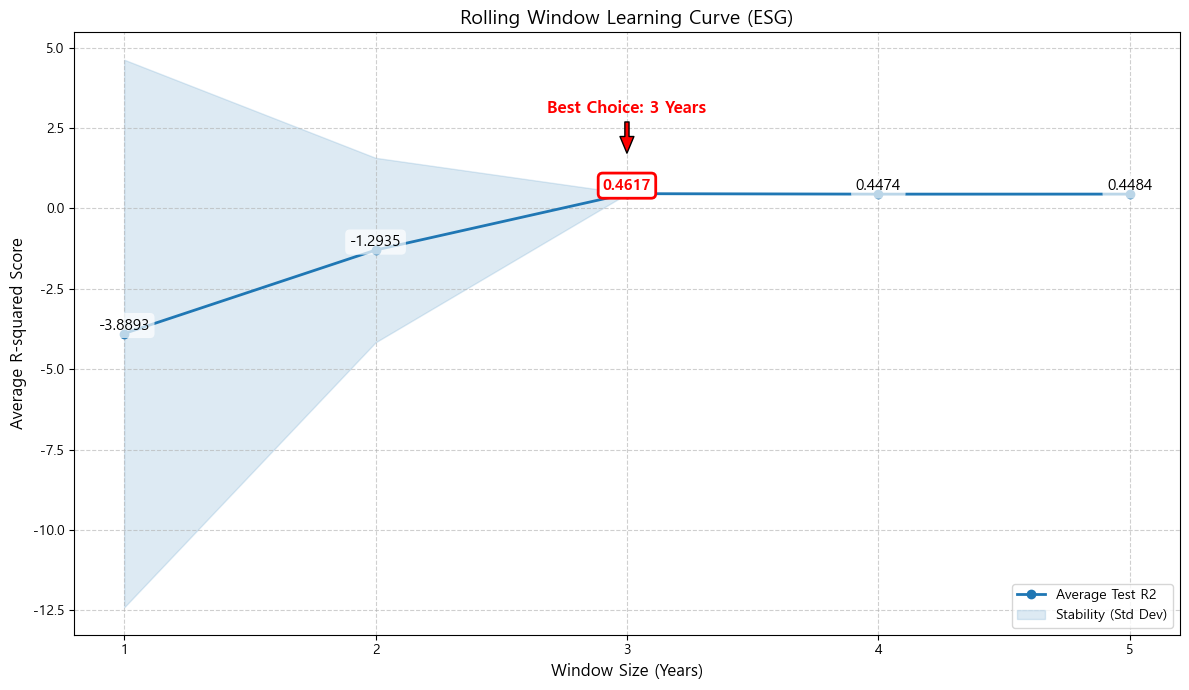

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# =============================================================================
# 1. [설정] 분석할 윈도우 크기 범위 설정 (1년 ~ 5년)
# =============================================================================
window_sizes = [1, 2, 3, 4, 5] 
target = 'ESG' 
base_features = [
    'ROA', 'SGR', 'LEV', 'A_SIZE', 'MSE',
    'FOR', 'TQ', 'ADV', 'R&D'
]

# 결과를 저장할 리스트
window_scores = []
window_stds = []

# =============================================================================
# 2. [실행] 각 윈도우 크기별로 롤링 윈도우 수행
# =============================================================================
print(f"=== {target} 모델 윈도우 크기별 성능 분석 중... ===")

for window in window_sizes:
    r2_per_step = []
    start_year = 2019 + window
    end_year = 2024
    
    for pred_year in range(start_year, end_year + 1):
        train_years = list(range(pred_year - window, pred_year))
        train_mask = df_final['year'].isin(train_years)
        test_mask = (df_final['year'] == pred_year)
        
        train_df = df_final[train_mask]
        test_df = df_final[test_mask]
        
        if len(train_df) < 10 or len(test_df) < 10: continue
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_df[base_features])
        X_test = scaler.transform(test_df[base_features])
        y_train = train_df[target]
        y_test = test_df[target]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        score = r2_score(y_test, model.predict(X_test))
        r2_per_step.append(score)
    
    if len(r2_per_step) > 0:
        avg_r2 = np.mean(r2_per_step)
        std_r2 = np.std(r2_per_step)
        window_scores.append(avg_r2)
        window_stds.append(std_r2)
    else:
        window_scores.append(0)
        window_stds.append(0)

# =============================================================================
# 3. [시각화] ★ 화살표 위치 대폭 수정 ★
# =============================================================================
plt.figure(figsize=(12, 7))

# 선 그래프
plt.plot(window_sizes, window_scores, 'o-', color='tab:blue', linewidth=2, label='Average Test R2')

# 표준편차(그림자)
upper_bound = np.array(window_scores) + np.array(window_stds)
lower_bound = np.array(window_scores) - np.array(window_stds)
plt.fill_between(window_sizes, lower_bound, upper_bound, color='tab:blue', alpha=0.15, label='Stability (Std Dev)')

# 최고점 값 찾기
max_score = max(window_scores)
best_window = window_sizes[window_scores.index(max_score)]

# --- 각 점 위에 수치 표기 ---
for x, y in zip(window_sizes, window_scores):
    label = f"{y:.4f}"
    
    if y == max_score:
        text_color = 'red'
        box_edge_color = 'red'
        box_lw = 2
        font_weight = 'bold'
        bg_alpha = 1.0 
    else:
        text_color = 'black'
        box_edge_color = 'none'
        box_lw = 0
        font_weight = 'normal'
        bg_alpha = 0.7

    # 텍스트 박스 그리기 (점 바로 위에 위치)
    plt.text(x, y, label, 
             fontsize=11, 
             color=text_color,
             fontweight=font_weight,
             ha='center', 
             va='bottom', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=box_edge_color, lw=box_lw, alpha=bg_alpha))

# --- [수정] 화살표 위치 재조정 ---
# 이전 값(0.15)은 너무 낮아서 박스를 찔렀습니다.
# 박스 높이를 고려해 1.2만큼 위로 올립니다. (그래프 Y축 눈금을 고려한 값)
arrow_end_y = max_score + 1.2 

# 화살표 시작 텍스트는 그보다 더 위(2.5)에 배치합니다.
annotation_height = max_score + 2.5

plt.annotate(f'Best Choice: {best_window} Years', 
             xy=(best_window, arrow_end_y), 
             xytext=(best_window, annotation_height), 
             arrowprops=dict(facecolor='red', shrink=0.05, width=3, headwidth=10),
             ha='center', fontsize=12, fontweight='bold', color='red')

plt.title(f'Rolling Window Learning Curve ({target})', fontsize=14)
plt.xlabel('Window Size (Years)', fontsize=12)
plt.ylabel('Average R-squared Score', fontsize=12)
plt.xticks(window_sizes)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()